# Fine-tuning Mixtral 8x7B using QLoRA 


Welcome to this detailed tutorial where we will guide you through the process of fine-tuning the Mixtral 8x7B model specifically for mathematical data. This hands-on guide is designed to help you build a customized version of the Mixtral 8x7B model that is tailored to understand and generate outputs based on mathematical datasets. Whether you are looking to enhance the model's capability in solving complex equations, understanding mathematical concepts, or generating mathematical content, this tutorial is for you.


We will talk about the methods involved.

## Step 1: Installation of Dependencies

We will be training on Google Collab. (Windows specific instructions are highlighted. For further details check `getting-started/init.pynb`)

In [ ]:
# You only need to run this once per machine, even if you stop/restart it
!pip install -q -U bitsandbytes
# For Windows:
# !pip install bitsandbytes==<version> --prefer-binary --extra-index-url=https://jllllll.github.io/bitsandbytes-windows-webui 
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q -U datasets scipy ipywidgets matplotlib

## Step 2: GPU setup

We can actually use the train function provided by Huggingface, but using accelerator allows us the flexibility of performing distributed computing. 

FullyShardedDataParallel allows us to load large models onto multiple GPUs by sharding.

You can read more here: https://huggingface.co/docs/accelerate/usage_guides/fsdp

In [ ]:
from accelerate import FullyShardedDataParallelPlugin, Accelerator
from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig

fsdp_plugin = FullyShardedDataParallelPlugin(
    state_dict_config=FullStateDictConfig(offload_to_cpu=True, rank0_only=False),
    optim_state_dict_config=FullOptimStateDictConfig(offload_to_cpu=True, rank0_only=False),
)

accelerator = Accelerator(fsdp_plugin=fsdp_plugin)

To track our metrics we are using Tensorboard. 

In [ ]:
# Tensorboard

!pip install tensorboard
%load_ext tensorboard

## Step 3: Load Dataset

We will be working with the MetaMathQA dataset today. This allows us to train our own math answering LLM.

To keep things simple. Let's just use the dataset as a whole.

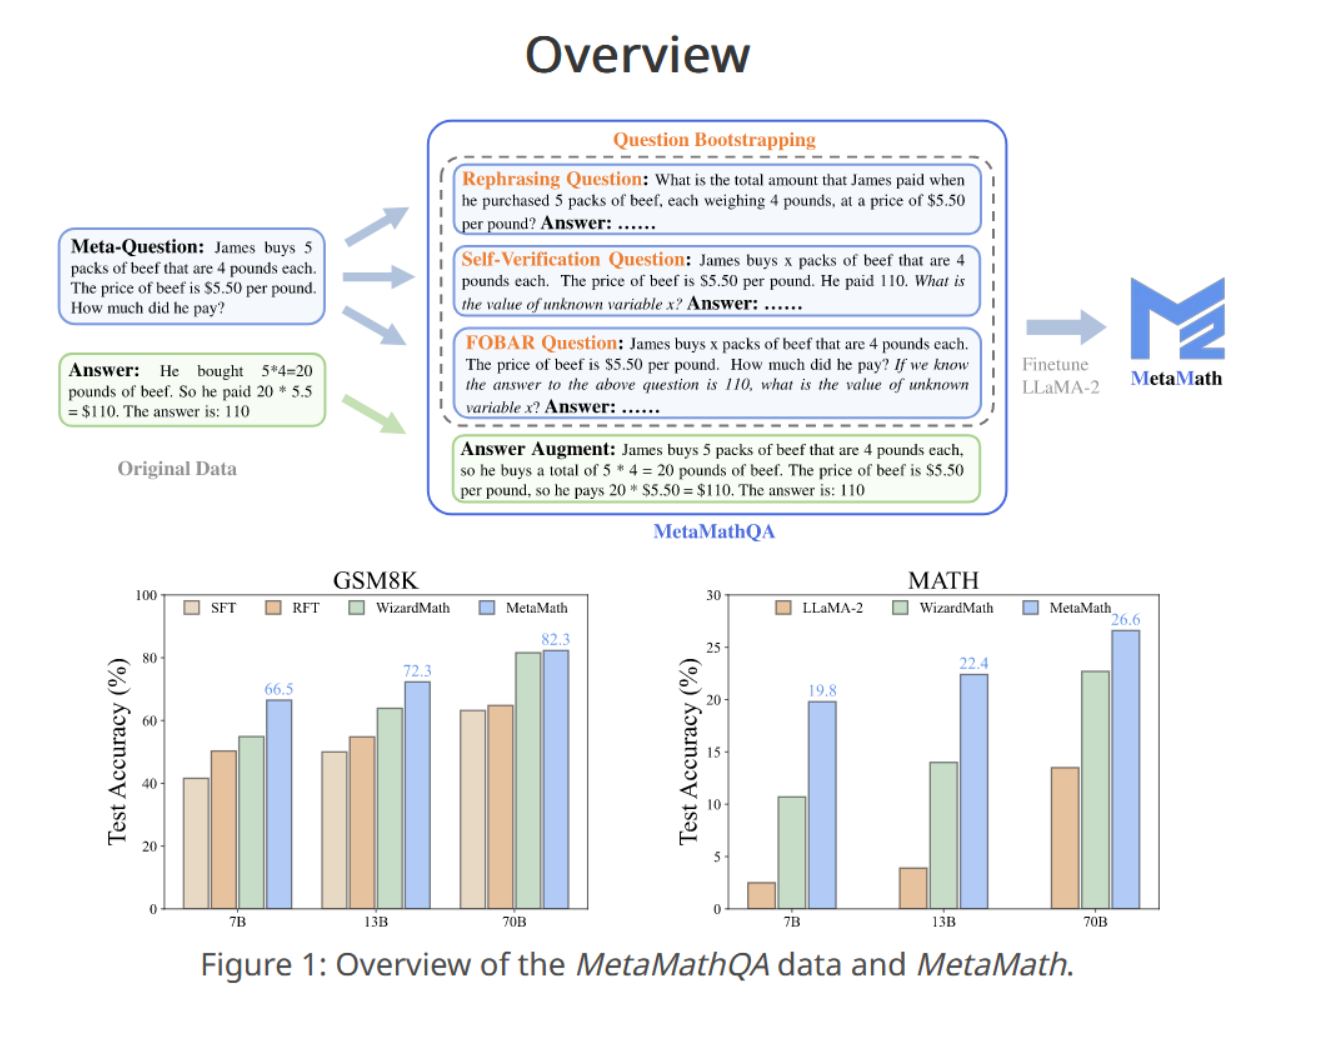


In [ ]:
from datasets import load_dataset

dataset_id = 'meta-math/MetaMathQA'

train_dataset = load_dataset(dataset_id, split='train[:70%]')
eval_dataset = load_dataset(dataset_id, split='train[70%:90%]')
test_dataset = load_dataset(dataset_id, split='train[90%:]')

len(train_dataset), len(eval_dataset), len(test_dataset)

In [ ]:
data_point = train_dataset[:1]


## Step 4: Load up Model

We are loading up the model with the 8 bit quantization (if you want to run it on a more lighter machine you can use 4 bit quantization as well). The BitsAndBytes handles the quantization.

Lower quantization would result in loss of information but makes it easier on weaker GPUs. There seems to be an issue running it on 8Bit quantization so we are using 4Bit quantization: https://github.com/TimDettmers/bitsandbytes/issues/736. 

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, DataCollatorForLanguageModeling, BitsAndBytesConfig

base_model_id = "mistralai/Mixtral-8x7B-v0.1"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config=bnb_config, device_map="cuda")

## Step 5: Dataset Processing

We want to set max_length, which affects your model compute each cycle. 

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_eos_token=True,
    add_bos_token=True, 
)

Setup the tokenize function to make labels and input_ids the same. This is basically what [self-supervised fine-tuning is](https://neptune.ai/blog/self-supervised-learning):

In [ ]:
def tokenize(prompt):
    result = tokenizer(prompt)
    result["labels"] = result["input_ids"].copy()
    return result

And convert each sample into a prompt that I found from [this notebook](https://github.com/samlhuillier/viggo-finetune/blob/main/llama/fine-tune-code-llama.ipynb).

In [ ]:
def generate_and_tokenize_prompt(data_point):
    full_prompt =f"""Given a target sentence construct the underlying meaning representation of the input sentence as a single function with attributes and attribute values.
This function should describe the target string accurately and the function must be one of the following ['inform', 'request', 'give_opinion', 'confirm', 'verify_attribute', 'suggest', 'request_explanation', 'recommend', 'request_attribute'].
The attributes must be one of the following: ['name', 'exp_release_date', 'release_year', 'developer', 'esrb', 'rating', 'genres', 'player_perspective', 'has_multiplayer', 'platforms', 'available_on_steam', 'has_linux_release', 'has_mac_release', 'specifier']

### Target sentence:
{data_point["target"]}

### Meaning representation:
{data_point["meaning_representation"]}
"""
    return tokenize(full_prompt)

Reformat the prompt and tokenize each sample:

In [ ]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt)

You can untokenize to make sure it was formatted properly.

In [ ]:
untokenized_text = tokenizer.decode(tokenized_train_dataset[1]['input_ids']) 
print(untokenized_text)

Let's get a distribution of our dataset lengths, so we can determine the appropriate `max_length` for our input tensors.

In [ ]:
import matplotlib.pyplot as plt

def plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

From here, you can choose where you'd like to set the `max_length` to be. You can truncate and pad training examples to fit them to your chosen size. Be aware that choosing a larger `max_length` has its compute tradeoffs.

Now let's tokenize again with padding and truncation, and set up the tokenize function to make labels and input_ids the same. This is basically what [self-supervised fine-tuning is](https://neptune.ai/blog/self-supervised-learning).

Add padding on the left as it [makes training use less memory](https://ai.stackexchange.com/questions/41485/while-fine-tuning-a-decoder-only-llm-like-llama-on-chat-dataset-what-kind-of-pa).

In [ ]:
max_length = 340 # This was an appropriate max length for my dataset

# redefine the tokenize function and tokenizer

tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,  
    add_bos_token=True,  
)
tokenizer.pad_token = tokenizer.eos_token


def tokenize(prompt):
    result = tokenizer(
        prompt,
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

In [ ]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt)

Check that `input_ids` is padded on the left with the `eos_token` (2) and there is an `eos_token` 2 added to the end, and the prompt starts with a `bos_token` (1).


In [ ]:
print(tokenized_train_dataset[4]['input_ids'])

You can also untokenize to see it in plain text. It should start with `<s>` and end with `</s>`.

In [ ]:
untokenized_text = tokenizer.decode(tokenized_train_dataset[1]['input_ids']) 
print(untokenized_text)

Now all the samples should be the same length, `max_length`.

In [ ]:
plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

#### How does the base model do?

Let's grab a test input (`meaning_representation`) and desired output (`target`) pair to see how the base model does on it.

In [ ]:
print("Target Sentence: " + test_dataset[1]['target'])
print("Meaning Representation: " + test_dataset[1]['meaning_representation'] + "\n")

In [ ]:
eval_prompt = """Given a target sentence construct the underlying meaning representation of the input sentence as a single function with attributes and attribute values.
This function should describe the target string accurately and the function must be one of the following ['inform', 'request', 'give_opinion', 'confirm', 'verify_attribute', 'suggest', 'request_explanation', 'recommend', 'request_attribute'].
The attributes must be one of the following: ['name', 'exp_release_date', 'release_year', 'developer', 'esrb', 'rating', 'genres', 'player_perspective', 'has_multiplayer', 'platforms', 'available_on_steam', 'has_linux_release', 'has_mac_release', 'specifier']

### Target sentence:
Earlier, you stated that you didn't have strong feelings about PlayStation's Little Big Adventure. Is your opinion true for all games which don't have multiplayer?

### Meaning representation:
"""

In [ ]:
# Apply the accelerator. You can comment this out to remove the accelerator.
model = accelerator.prepare_model(model)

In [ ]:
# Re-init the tokenizer so it doesn't add padding or eos token
eval_tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_bos_token=True,
)

In [ ]:
device = "cuda"
model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to(device)

In [ ]:
model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(model.generate(**model_input, max_new_tokens=128)[0], skip_special_tokens=True))

We can see it doesn't do very well out of the box.

## Step 6: Setup LoRA

`r` defines the rank of decomposition, which controls the parameters trained. If you use a larger r, you will train more layers. But since the models are large, this means it is heavier to trian. 

`alpha` scales the learned weights wrt to the original weights. A higher alpha would prefer the weights that you have finetuned.

You can learn more here: https://medium.com/@manyi.yim/more-about-loraconfig-from-peft-581cf54643db

Now, to start our fine-tuning, we have to apply some preprocessing to the model to prepare it for training. For that use the `prepare_model_for_kbit_training` method from PEFT.

In [ ]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [ ]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

Let's print the model to examine its layers, as we will apply QLoRA to all the linear layers of the model. Those layers are `q_proj`, `k_proj`, `v_proj`, `o_proj`, `w1`, `w2`, `w3`, and `lm_head`.

In [ ]:
print(model)

Here we define the LoRA config.

`r` is the rank of the low-rank matrix used in the adapters, which thus controls the number of parameters trained. A higher rank will allow for more expressivity, but there is a compute tradeoff.

`alpha` is the scaling factor for the learned weights. The weight matrix is scaled by `alpha/r`, and thus a higher value for `alpha` assigns more weight to the LoRA activations.

The values used in the QLoRA paper were `r=64` and `lora_alpha=16`, and these are said to generalize well, but we will use `r=8` and `lora_alpha=16` so that we have more emphasis on the new fine-tuned data while also reducing computational complexity.

In [ ]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "w1",
        "w2",
        "w3",
        "lm_head",
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

# Apply the accelerator. You can comment this out to remove the accelerator.
model = accelerator.prepare_model(model)

See how the model looks different now, with the LoRA adapters added:

In [ ]:
print(model)

## Training

First as always, run the model for 5 steps and see that nothing breaks. 

Then you can run it for 500 steps and see when overfitting is occuring. Correspondingly, use the appropriate checkpoint that is generated.
You can interrupt the process via Kernel -> Interrupt Kernel in the top nav bar once you realize you didn't need to train anymore.

In [ ]:
if torch.cuda.device_count() > 1: # If more than 1 GPU
    model.is_parallelizable = True
    model.model_parallel = True

In [ ]:
torch.cuda.device_count() # should be 4 if using Brev's instance link

In [ ]:
import transformers
from datetime import datetime

project = "viggo-finetune"
base_model_name = "mixtral"
run_name = base_model_name + "-" + project
output_dir = "./" + run_name

tokenizer.pad_token = tokenizer.eos_token

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=5,
        per_device_train_batch_size=1,
        gradient_checkpointing=True,
        gradient_accumulation_steps=4,
        max_steps=1000,
        learning_rate=2.5e-5, 
        logging_steps=25,
        fp16=True, 
        optim="paged_adamw_8bit",
        logging_dir="./logs",        # Directory for storing logs
        save_strategy="steps",       # Save the model checkpoint every logging step
        save_steps=50,                # Save checkpoints every 50 steps
        evaluation_strategy="steps", # Evaluate the model every logging step
        eval_steps=50,               # Evaluate and save checkpoints every 50 steps
        do_eval=True,                # Perform evaluation at the end of training
        report_to="wandb",           # Comment this out if you don't want to use weights & baises
        run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"          # Name of the W&B run (optional)
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

I cleared the output of the cell above because I stopped the training early, and it produced a long, ugly error message.

## Test your model

It's a good idea to kill the current process so that you don't run out of memory loading the base model again on top of the model we just trained. Go to `Kernel > Restart Kernel` or kill the process via the Terminal (`nvidia smi` > `kill [PID]`). 

By default, the PEFT library will only save the QLoRA adapters, so we need to first load the base Mixtral model from the Huggingface Hub:


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "mistralai/Mixtral-8x7B-v0.1"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16
)

base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,  # Mixtral, same as before
    quantization_config=bnb_config,  # Same quantization config as before
    device_map="auto",
    trust_remote_code=True,
)

eval_tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_bos_token=True,
    trust_remote_code=True,
)

Now load the QLoRA adapter from the appropriate checkpoint directory, i.e. the best performing model checkpoint:

In [ ]:
from peft import PeftModel

ft_model = PeftModel.from_pretrained(base_model, "mixtral-viggo-finetune-2/checkpoint-500")

and run your inference!

Let's try the same `eval_prompt` and thus `model_input` as above, and see if the new finetuned model performs better.

In [ ]:
eval_prompt = '''"Below is an instruction that describes a task. " 
"Write a response that appropriately completes the request." 

"### Instruction:

Gracie and Joe are choosing numbers on the complex plane. Joe chooses the point $1+2i$. Gracie chooses $-1+i$. How far apart are Gracie and Joe's points?


### Response: Let's think step by step."'''


model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=100)[0], skip_special_tokens=True))

## References

This project uses code from the following source:
- **Brev Notebooks**: Available at: [URL to the original source](https://github.com/brevdev/notebooks)
